# Sketching AutoEncoder with a single polyline

This notebook demonstrates an autoencoder that predicts both a list of 2d points describing a polyline. Lines between each possible pair of points are drawn into separate rasters before being merged into a single image with a compositing function. Only the encoder network has learnable parameters; the decoder is entirely deterministic, but differentiable.

The network is defined below; the number of points can be configured.

In [13]:
import torch
import torch.nn as nn
from dsketch.raster.disttrans import line_edt2
from dsketch.raster.raster import exp
from dsketch.raster.composite import softor

class AE(nn.Module):
  def __init__(self, npoints=8, hidden=64, sz=28):
    super(AE, self).__init__()

    # build the coordinate grid:
    r = torch.linspace(-1, 1, sz)
    c = torch.linspace(-1, 1, sz)
    grid = torch.meshgrid(r, c)
    grid = torch.stack(grid, dim=2)
    self.register_buffer("grid", grid)
    
    # this is a list of pairs of "connections" 0-1, 1-2, 2-3, ...
    self.coordpairs = torch.stack([torch.arange(0,npoints-1,1), torch.arange(1,npoints,1)], dim=1)

    self.enc = nn.Sequential(
        nn.Linear(sz**2, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, npoints*2),
        nn.Tanh()
    )

  def forward(self, inp, sigma=1e-4):
    # the encoding process will flatten the input and
    # push it through the encoder networks
    bs = inp.shape[0]
    x = inp.view(bs, -1)
    pts = self.enc(x) #[batch, npoints*2]
    pts = pts.view(bs, -1, 2) # expand -> [batch, npoints, 2]
    
    # compute all valid permuations of line start and end points
    lines = torch.stack((pts[:,self.coordpairs[:,0]], pts[:,self.coordpairs[:,1]]), dim=-2) #[batch, nlines, 2, 2]

    # Rasterisation steps
    # draw the lines (for every input in the batch)
    rasters = exp(line_edt2(lines, self.grid), sigma) # -> [batch * nlines, 28, 28]
    
    # composite
    return softor(rasters)

We'll do a simple test on MNIST and try and train the AE to be able to reconstruct digit images (and of course at the same time perform image vectorisation/autotracing of polylines). Hyperparameters are pretty arbitrary (defaults for Adam; 256 batch size), although we do anneal the rasteriser scale each epoch (to a point) to initially allow better gradient flow from further away.

In [14]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
import torchvision

batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(28, 28))
    ])
trainset = torchvision.datasets.MNIST('/tmp', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST('/tmp', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


sigma=1e-1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AE(npoints=16).to(device)

opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
  for images, classes in trainloader:
    images = images.to(device)
    opt.zero_grad()
    out = model(images, sigma)
    loss = nn.functional.mse_loss(out, images)
    loss.backward()
    opt.step()

  if sigma > 1e-2:
    sigma *= 0.5

  print(loss, sigma)

tensor(0.1284, device='cuda:0', grad_fn=<MseLossBackward>) 0.05
tensor(0.0828, device='cuda:0', grad_fn=<MseLossBackward>) 0.025
tensor(0.0577, device='cuda:0', grad_fn=<MseLossBackward>) 0.0125
tensor(0.0385, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625


Finally here's a visualisation of a set of test inputs and their rendered reconstructions:

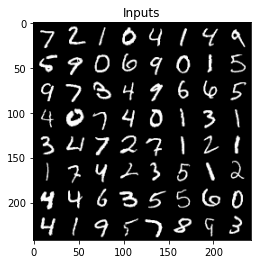

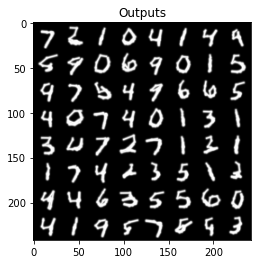

In [15]:
batch = iter(testloader).next()[0][0:64]
out = model(batch.to(device), sigma=1e-2)

plt.figure()
inputs = torchvision.utils.make_grid(batch.unsqueeze(1))
plt.title("Inputs")
plt.imshow(inputs.permute(1,2,0))

plt.figure()
outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
plt.title("Outputs")
plt.imshow(outputs.permute(1,2,0))

# model.rasteriser.rasteriser.mode = 'nn'
# out = model(batch.cuda())
# plt.figure()
# outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
# plt.title("Outputs - hard")
# plt.imshow(outputs.permute(1,2,0))